# Random Forests

Temeli, birden çok karar ağacının ürettiği tahminlerin, bir araya getirilerek değerlendirilmesine dayanır.

- Bagging(Breiman, 1996) ile Random Subspace(Ho, 1998) yöntemlerinin birleşimi ile oluşmuştur.

- Ağaçlar için gözlemler bootstrap rastgele örnek seçim yöntemi ile değişkenler random subspace yöntemi ile seçilir.

- Karar ağacının her bir düğümünde en iyi dallara ayırıcı(bilgi kazancı) değişken tüm değişkenler arasından rastgele seçilen daha az sayıdaki değişkenler arasından seçilir.

- Ağaç oluşturmada veri setinin 2/3'ü kullanılır. Dışarıda kalan veri ağaçların performans değerlendirmesi ve değişken öneminin belirlenmesi için kullanılır.

- Her düğüm noktasında rastgele değişken seçimi yapılır. (regresyon'da p/3, sınıflandırma'da karekök p)

- Nihai tahmin için ağaçlardan tahmin değerleri talep edilirken her bir ağacın daha önce hesaplanan hata oranları göz önüne alınarak ağaçlara ağırlık verilir.

2001, Breiman

------

# 1. Model (RF)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
hit = pd.read_csv("Hitters.csv")

df = hit.copy()

df = df.dropna()

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
dms = pd.get_dummies(df[["League", "Division", "NewLeague"]])

dms.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [4]:
X_ = df.drop(["Salary", "League", "Division", "NewLeague"], axis = 1).astype("float64")

X_.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0


In [5]:
X = pd.concat([X_, dms[["League_N", "Division_W", "NewLeague_N"]]], axis = 1)

X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [6]:
y = df["Salary"]

y.head()

1    475.0
2    480.0
3    500.0
4     91.5
5    750.0
Name: Salary, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [8]:
rf_model = RandomForestRegressor(random_state = 42)

In [9]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

---------

# 2. Tahmin (RF)

In [10]:
rf_model.predict(X_test)

array([ 782.2   , 1071.75  , 1619.    ,  147.4167,  671.    ,  335.75  ,
        205.6   ,  116.25  ,  854.95  ,  444.25  ,  762.8333,  926.25  ,
        529.    ,  155.2   ,  350.    ,  821.25  , 1007.    ,   93.05  ,
        871.45  ,  231.    ,  408.5   ,  990.6667,  679.3333,  530.6667,
        450.5   ,   78.3   ,  737.4167,  332.5   ,  789.5   ,   88.55  ,
         87.05  ,  498.25  ,  434.4168,  234.    ,  283.6667,  957.1666,
       1364.75  ,  186.5   ,  165.    ,  471.5834,   81.9   ,  135.    ,
        680.2   ,  784.    , 1446.0571,  893.4166,  435.5   ,  107.5   ,
        144.    ,  861.    ,  817.3333,  676.0833,  752.6167,  186.    ,
        103.75  , 1070.3333,  655.5   ,  536.8333,  197.0334, 1538.1975,
       1162.6667,  470.    ,  705.8333,  393.    ,  658.5   ,   75.05  ])

In [12]:
y_pred_test = rf_model.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred_test))

373.04044281427

-----------

# 3. Model Doğrulama / Model Tuning (RF)

In [13]:
rf_params = {"max_depth" : list(range(1, 10)),
            "max_features" : [2, 3, 4, 5, 6, 10, 15],
            "n_estimators" : [100, 200, 500, 1000, 2000]}

In [14]:
rf_model = RandomForestRegressor(random_state = 42)

In [15]:
# işlemcinin daha hızlı, daha performanslı çalışması için 'n_jobs = 1' i ekliyoruz.

rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1)

In [16]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7,

In [17]:
rf_cv_model.best_params_

{'max_depth': 6, 'max_features': 2, 'n_estimators': 100}

In [18]:
# final modelimiz

rf_tuned = RandomForestRegressor(max_depth = 6, max_features = 2, n_estimators = 100)

rf_tuned.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [19]:
y_pred = rf_tuned.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

348.5544032617836

In [25]:
rf_tuned.feature_importances_

array([0.05621594, 0.05610647, 0.0307457 , 0.04323909, 0.05091218,
       0.06423811, 0.06619785, 0.08799546, 0.10004961, 0.07394851,
       0.09406889, 0.09098647, 0.1050666 , 0.03493881, 0.01772229,
       0.01379422, 0.0040168 , 0.0058812 , 0.00387581])

In [21]:
Importance = pd.DataFrame({"Importance" : rf_tuned.feature_importances_ * 100}, index = X_train.columns)

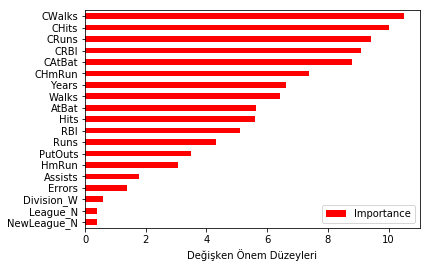

In [24]:
Importance.sort_values(by = "Importance", axis = 0, ascending = True).plot(kind = "barh", color = "red")

plt.xlabel("Değişken Önem Düzeyleri");

-----------------